In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import json
from simpletransformers.classification import ClassificationModel,ClassificationArgs
import torch
import re, string

%matplotlib inline

#print("gensim: " + gensim.__version__)
# print("tensorflow: " + tensorflow.__version__)
# print("keras: " + keras.__version__)

/home/cathylab/anaconda3/envs/ivy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-25 20:18:11.735520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 20:18:11.822636: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 20:18:12.205764: W tensorflow/compiler/xla/stream_executor/platform/default/d

### Load data

In [2]:
### data
emotion = pd.read_csv("emotion.csv")
data_identification = pd.read_csv("data_identification.csv")

#### The .json file include the main data. It needs the pd.json_normalize() to flatten its structure and to get the information we need (text).

In [3]:
# load data using Python JSON module
with open('tweets_DM.json','r') as f:
    #data = json.loads(f.read())
    data = [json.loads(line) for line in f]
    
# Normalizing data
tweets_DM = pd.json_normalize(data)

In [4]:
tweets_DM_selected = tweets_DM.rename(columns = {"_source.tweet.tweet_id": "tweet_id", "_source.tweet.text": "text"})[['tweet_id', 'text']]
tweets_DM_selected.head()

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."


#### Merge multiple dataframe for further usage
Then split the data into training and testing set by the "identification" column. Drop the unwanted columns afterward.

In [5]:
id_text_iden = tweets_DM_selected.merge(data_identification, how='outer', on='tweet_id')
id_text_iden.head()

,tweet_id,text,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,0x28b412,"Confident of your obedience, I write to you, k...",test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test


In [6]:
train_info_df = id_text_iden.loc[id_text_iden['identification'] == 'train']
test_df = id_text_iden.loc[id_text_iden['identification'] == 'test']
train_df = train_info_df.merge(emotion, how='outer', on='tweet_id')

In [7]:
train_df.drop(['tweet_id', 'identification'], axis=1, inplace=True)
test_df.drop(['identification'], axis=1, inplace=True)

/tmp/ipykernel_6455/2274263513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['identification'], axis=1, inplace=True)


In [8]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

### Plot the distribution of our data

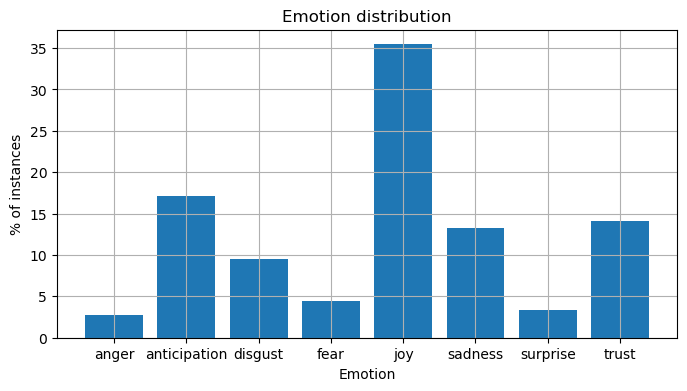

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

#### Since we have highly biased data, I was thinking about maybe sampling each class into the same amount may help. Turn out, it didn't. Thus I do not use this method in my final submission.

In [35]:
# sampling data
new_df = train_df.groupby(['emotion']).sample(n=30000)
new_df.groupby(['emotion']).count()['text']

emotion
anger           30000
anticipation    30000
disgust         30000
fear            30000
joy             30000
sadness         30000
surprise        30000
trust           30000
Name: text, dtype: int64

Shuffle dataset

In [45]:
new_df = new_df.sample(frac=1)
new_df

,text,emotion
61395,"So I missed a pill about three days ago, but I...",5
397266,esk speaking weiii... <LH> #muet,3
468691,So now everyone Wants money for sleeping wth #...,2
776814,<LH> #LosAngeles and #friends. Say <LH> #Neigh...,4
675139,People are strange but what they think is even...,6
...,...,...
1006790,@mattwilson_star morning matt getting worried ...,0
291850,Looking forward to my keynote tomorrow @PENZ_T...,7
219654,@chubby6665 Great insight on Sky into your bus...,3
1107776,"Do me a favor, train the WOMEN this time. #Afg...",0


Change the word-form emotions into number-form.

In [10]:
emotion_state = {
    'anger': 0,
    'anticipation': 1,
    'disgust': 2,
    'fear': 3,
    'joy': 4,
    'sadness': 5,
    'surprise': 6,
    'trust': 7}

new_df = train_df.replace({"emotion": emotion_state})
# train_df.head(10)

In [11]:
train_df = new_df.rename(columns = {"text":"text", "emotion": "labels"})[['text','labels']]
train_df.head()

,text,labels
0,"People who post ""add me on #Snapchat"" must be ...",1
1,"@brianklaas As we see, Trump is dangerous to #...",5
2,Now ISSA is stalking Tasha 😂😂😂 <LH>,3
3,@RISKshow @TheKevinAllison Thx for the BEST TI...,4
4,Still waiting on those supplies Liscus. <LH>,1


In [12]:
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [13]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

#### Split training data into taining and validation part.

In [14]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df, train_size=0.8)

### Using Bag of Words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
import nltk
nltk.download('punkt')

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_data['text'])

train_data_BOW_features_500 = BOW_500.transform(train_data['text'])

## check dimension
train_data_BOW_features_500.shape

[nltk_data] Downloading package punkt to /home/cathylab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/cathylab/anaconda3/envs/ivy/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1164450, 500)

In [17]:
train_data_BOW_features_500.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['can', 'car', 'care', 'change', 'christ', 'christmas', 'closed',
       'come', 'comes', 'coming'], dtype=object)

In [19]:
"😂" in feature_names_500

True

In [20]:
train_data.head()

,text,labels
842335,Really feeling this weather! <LH>,4
476118,I love his apron. 👌🏾 #44 <LH>,3
127211,32 Push the <LH> #everyday. Be some #special. ...,4
351107,I didn't come up. God came through <LH>,4
211360,@ohiodeplorable1 Thank you VERY much for the f...,1


In [21]:
test_df.head()

,tweet_id,text
2,0x28b412,"Confident of your obedience, I write to you, k..."
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
9,0x218443,When do you have enough ? When are you satisfi...
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #..."
33,0x26289a,"In these tough times, who do YOU turn to as yo..."


### Prepare data for NN model

In [22]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_data['text'])
y_train = train_data['labels']

X_val = BOW_500.transform(val_data['text'])
y_val = val_data['labels']

X_test = BOW_500.transform(test_df['text'])

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)
print('X_test.shape: ', X_test.shape)

X_train.shape:  (1164450, 500)
y_train.shape:  (1164450,)
X_val.shape:  (291113, 500)
y_val.shape:  (291113,)
X_test.shape:  (411972, 500)


In [23]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_val.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_val = label_encode(label_encoder, y_val)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_val.shape)

check label:  [0 1 2 3 4 5 6 7]

## Before convert
y_train[0:4]:
 842335    4
476118    3
127211    4
351107    4
Name: labels, dtype: int64

y_train.shape:  (1164450,)
y_test.shape:  (291113,)


## After convert
y_train[0:4]:
 [[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]

y_train.shape:  (1164450, 8)
y_test.shape:  (291113, 8)


/tmp/ipykernel_6455/126661130.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print('y_train[0:4]:\n', y_train[0:4])


In [24]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  8


### Build model
#### I add more hidden layers and add batch normalization before each activation function, hoping the model can perform better.

In [25]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.layers import BatchNormalization

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
BN_1 = BatchNormalization()(X_W1)
H1 = ReLU()(BN_1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
BN_2 = BatchNormalization()(H1_W2)
H2 = ReLU()(BN_2)

# 3rd hidden layer
H2_W3 = Dense(units=32)(H2)  # 32
BN_3 = BatchNormalization()(H2_W3)
H3 = ReLU()(BN_3)

# 4th hidden layer
H3_W4 = Dense(units=16)(H3)  # 16
BN_4 = BatchNormalization()(H3_W4)
H4 = ReLU()(BN_4)

# output layer
H4_W5 = Dense(units=output_shape)(H4)  # 4
BN_5 = BatchNormalization()(H4_W5)
H5 = Softmax()(BN_5)

model_output = H5

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

2022-11-25 20:31:18.289638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:31:18.310078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:31:18.310368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:31:18.311567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

### Train model

In [26]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_val, y_val))
print('training finish')

Epoch 1/25


2022-11-25 20:31:32.900591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-25 20:31:32.926177: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6674006180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-25 20:31:32.926202: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2022-11-25 20:31:32.945353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-25 20:31:33.158946: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36390/36390 [==============================] - 299s 8ms/step - loss: 1.4718 - accuracy: 0.4662 - val_loss: 1.3997 - val_accuracy: 0.4891
Epoch 2/25
36390/36390 [==============================] - 286s 8ms/step - loss: 1.4183 - accuracy: 0.4843 - val_loss: 1.3889 - val_accuracy: 0.4927
Epoch 3/25
36390/36390 [==============================] - 264s 7ms/step - loss: 1.4056 - accuracy: 0.4893 - val_loss: 1.3817 - val_accuracy: 0.4948
Epoch 4/25
36390/36390 [==============================] - 268s 7ms/step - loss: 1.3981 - accuracy: 0.4920 - val_loss: 1.3773 - val_accuracy: 0.4974
Epoch 5/25
36390/36390 [==============================] - 276s 8ms/step - loss: 1.3926 - accuracy: 0.4942 - val_loss: 1.3754 - val_accuracy: 0.4973
Epoch 6/25
36390/36390 [==============================] - 286s 8ms/step - loss: 1.3892 - accuracy: 0.4955 - val_loss: 1.3726 - val_accuracy: 0.4995
Epoch 7/25
36390/36390 [==============================] - 275s 8ms/step - loss: 1.3866 - accuracy: 0.4961 - val_loss: 1.370

In [27]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.466218,1.471794,0.489126,1.399654
1,1,0.484255,1.418339,0.492699,1.388921
2,2,0.489338,1.405646,0.494784,1.381714
3,3,0.492008,1.398108,0.497412,1.377332
4,4,0.494231,1.392637,0.497267,1.375436
5,5,0.495528,1.389159,0.499493,1.372609
6,6,0.496148,1.386557,0.499926,1.370216
7,7,0.497292,1.383431,0.500761,1.369992
8,8,0.498164,1.381306,0.500816,1.368675
9,9,0.498881,1.379649,0.501098,1.368270


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


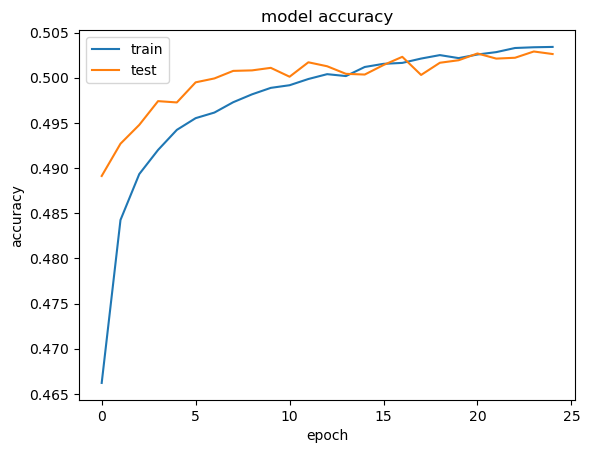

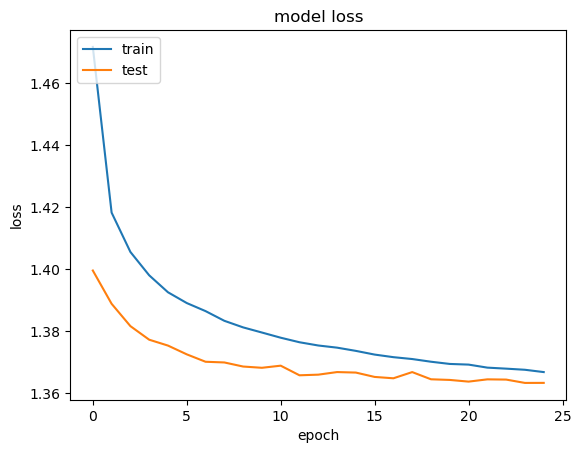

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
test_df.head()

,tweet_id,text
2,0x28b412,"Confident of your obedience, I write to you, k..."
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
9,0x218443,When do you have enough ? When are you satisfi...
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #..."
33,0x26289a,"In these tough times, who do YOU turn to as yo..."


In [30]:
X_test

<411972x500 sparse matrix of type '<class 'numpy.int64'>'
	with 6280412 stored elements in Compressed Sparse Row format>

### Make a prediction on the testing set

In [31]:
pred=model.predict(X_test)

12875/12875 [==============================] - 28s 2ms/step


In [33]:
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3219/3219 [==============================] - 7s 2ms/step


array([[5.77433826e-03, 5.84869266e-01, 1.25888633e-02, 4.65982314e-03,
        2.88907826e-01, 1.77788641e-02, 4.89473622e-03, 8.05262551e-02],
       [2.48843542e-04, 8.18437278e-01, 5.61965629e-04, 7.18909968e-03,
        4.48356196e-02, 2.99817487e-03, 1.54454866e-03, 1.24184430e-01],
       [3.40804979e-02, 1.82378307e-01, 1.25231892e-01, 1.22396955e-02,
        1.34901851e-01, 4.40304428e-01, 1.81568731e-02, 5.27064353e-02],
       [9.65316407e-03, 3.10483187e-01, 3.77928205e-02, 1.01384837e-02,
        3.98021072e-01, 2.96495613e-02, 1.44154914e-02, 1.89846218e-01],
       [1.91905610e-02, 3.92812937e-01, 5.19422740e-02, 2.43072771e-02,
        2.11813986e-01, 4.53452058e-02, 1.23286648e-02, 2.42259055e-01]],
      dtype=float32)

In [35]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array([1, 1, 5, 4, 1])

In [38]:
pred_df = pd.DataFrame(pred_result.tolist(), columns =['prediction'])
pred_df

,prediction
0,1
1,1
2,5
3,4
4,1
...,...
411967,4
411968,1
411969,2
411970,4


#### Add the predicted result into our test_df and arrange the dataframe

In [40]:
test_df.reset_index(drop=True, inplace=True)
pred_df.reset_index(drop=True, inplace=True)

test_pred_df = pd.concat([test_df, pred_df], axis=1) 
test_pred_df.head()

,tweet_id,text,prediction
0,0x28b412,"Confident of your obedience, I write to you, k...",1
1,0x2de201,"""Trust is not the same as faith. A friend is s...",1
2,0x218443,When do you have enough ? When are you satisfi...,5
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",4
4,0x26289a,"In these tough times, who do YOU turn to as yo...",1


Change the number-form emotions back to the word form.

In [41]:
inv_emo = {v: k for k, v in emotion_state.items()}
inv_emo

{0: 'anger',
 1: 'anticipation',
 2: 'disgust',
 3: 'fear',
 4: 'joy',
 5: 'sadness',
 6: 'surprise',
 7: 'trust'}

In [44]:
test_emo_df = test_pred_df.replace({"prediction": inv_emo})
test_emo_df.head()

,tweet_id,text,prediction
0,0x28b412,"Confident of your obedience, I write to you, k...",anticipation
1,0x2de201,"""Trust is not the same as faith. A friend is s...",anticipation
2,0x218443,When do you have enough ? When are you satisfi...,sadness
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",joy
4,0x26289a,"In these tough times, who do YOU turn to as yo...",anticipation


In [45]:
ans_df = test_emo_df.drop(['text'], axis=1)
ans_df.head()

,tweet_id,prediction
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,sadness
3,0x2939d5,joy
4,0x26289a,anticipation


#### Make the final dataframe in the same form as the sample submission.

In [46]:
ans_df.rename(columns={'tweet_id': 'id', 'prediction': 'emotion'}, inplace=True)
ans_df.head()

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,sadness
3,0x2939d5,joy
4,0x26289a,anticipation


### Save our prediction!

In [47]:
ans_df.to_csv('NN_ans.csv', encoding='utf-8', index=False)